# Compaction Solver

This notebook solves the viscous compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

Set the main dimensional parameters in the problem:            
(**note:** to modify these paramters after running the cell, you have to restart the kernel)

In [2]:
import meta_params as mp
mp.H0 = 0.02                                     # initial column height (m)
mp.w0 = 100/3.154e7                              # prescribed compaction rate (m/s)
mp.phi0 = 0.5                                   # initial porosity 
mp.eta = 1e7                                     # Viscosity scale (Pa s)
mp.Pi0 = 10*1e3                                  # Plastic stress prefactor (Pa)
mp.k0 = 1e-14                                    # permeability pre-factor (m^2)
mp.t_f = 100*60                                  # Final time (s)

Note: you can modify the constitutive relations in **constitutive.py** before proceeding!

In [3]:
# import necessary ingredients
import matplotlib.pyplot as plt
import numpy as np
from dolfinx.fem import Constant, Function, FunctionSpace
from dolfinx.mesh import create_interval
from mpi4py import MPI
from params import eta, H0, nt, nz, phi0, w0, zeta, delta, gamma, dt, rho_b
from petsc4py import PETSc
from solvers import full_solve, vel_solve
from ufl import FiniteElement, MixedElement

In [4]:
# print some stuff
print('compaction length delta = '+'{:.3f}'.format(delta)+' m')
print('density = '+'{:.0f}'.format(rho_b)+' kg/m^3')

compaction length delta = 0.140 m
density = 459 kg/m^3


Define domain:

In [5]:
# generate mesh, initial domain is scaled height of 1 
domain = create_interval(MPI.COMM_WORLD,nz,[0,1])

Define initial porosity:

In [6]:
# piecewise linear finite elements
P1 = FiniteElement('P',domain.ufl_cell(),1)     
element = P1*P1
V = FunctionSpace(domain,element)   
initial = Function(V)
initial.sub(1).interpolate(lambda x:phi0+0*x[0])

Define the boundary conditions (stress or velocity) at the top of the domain:

In [7]:
# # Dirichlet condition: set compaction rate (velocity) at the top
# bc_top = {'type': 'velocity', 'value': -1}

# # Neumann condition: set the load (stress) at the top
stress = 1e5 # units: Pa
stress_scale = w0*((4./3.)*eta + zeta)/H0 
bc_top = {'type': 'stress', 'value': stress/stress_scale}

Solve the momentum balance with the initial porosity to obtain the initial velocity:

In [8]:
w_i = vel_solve(domain,initial.sub(1),bc_top)
initial.sub(0).interpolate(w_i)

Solve the full problem over all time steps:

In [9]:
w,phi,sigma,z = full_solve(domain,initial,bc_top)

Plot the solution:

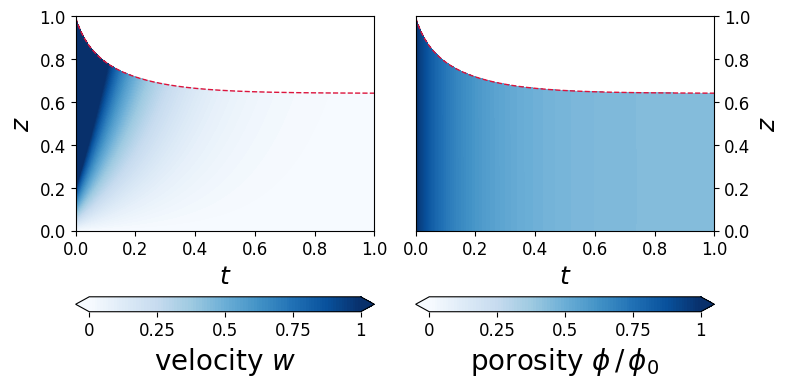

In [10]:
# time array for plotting
t = np.outer(np.linspace(0,1,nt),np.ones(nz+1))
sigma0 = np.abs(sigma[0,-1])
d = int(np.abs(sigma).max()/sigma0)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t[:,0],z[:,-1],'--',color='crimson',linewidth=1)
plt.contourf(t,z,-w,cmap='Blues',levels=np.linspace(0,1,100),extend='both')
plt.ylabel(r'$z$',fontsize=18)
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(orientation='horizontal',pad=0.2,ticks=np.linspace(0,1,5))
cbar.set_label(r'velocity $w$',fontsize=20)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticklabels([0,0.25,0.5,0.75,1])
plt.ylim(0,1)


plt.subplot(122)
plt.plot(t[:,0],z[:,-1],'--',color='crimson',linewidth=1)
plt.contourf(t,z,phi/phi0,cmap='Blues',levels=np.linspace(0,1,100),extend='both')
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=12)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel(r'$z$',fontsize=18)
plt.yticks(fontsize=12)
cbar = plt.colorbar(orientation='horizontal',pad=0.2,ticks=np.linspace(0,1,5))
cbar.set_label(r'porosity $\phi\,/\,\phi_0$',fontsize=20)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticklabels([0,0.25,0.5,0.75,1])
plt.ylim(0,1)

plt.tight_layout()
plt.savefig('compaction')
plt.show()
plt.close()

In [11]:
# # Stress-displacement plot
# # Note: should be constant if Neumann condition is prescribed
# #
# # import data for comparison if available
# fname = 'data_name.csv'
# data = np.genfromtxt(fname, delimiter=',')
# dH_data = data[:,0]    # 0 
# sigma_data = data[:,2] # 2

# dH = -(z[:,-1] - z[0,-1])
# dH_sc =  H0*1e3
# sigma_H = sigma[:,-1]-sigma[0,-1]          # subtract off initial stress...?!

# plt.figure(figsize=(8,6))
# plt.plot(dH*dH_sc,sigma_H/1e3,color='royalblue',linewidth=3)
# # plt.plot(dH_data,sigma_data,color='crimson',marker='o',markersize=8)
# plt.ylabel(r'$\Sigma-\Sigma_0$ (kPa)',fontsize=20)
# plt.xlabel(r'$\delta$ (mm)',fontsize=20)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.ylim(-10,150)
# plt.show()
# plt.close()